# Filtering and trimming messages

## Review

By now, we have a deeper understanding of a few key concerns: 

* How to define various state schemas
* How to define custom state reducers
* How to use multiple states within your graph

## Goals

Now, we can start using these concepts with with chat models in LangGraph.

We'll build towards a chatbot that has long-term memory!

Let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Messages as state

First, let's define some messages.

In [48]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.extend([HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance")])

from pprint import pprint
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='There are many fascinating ocean mammals beyond whales that you might want to learn about. Here\'s a brief overview of some of them:\n\n1. **Dolphins**: Highly intelligent and social animals. Species include the common bottlenose dolphin and the orca (which is actually a type of dolphin).\n\n2. **Porpoises**: Similar to dolphins but generally smaller, with different teeth and body shapes. The harbor porpoise is a common example.\n\n3. **Seals**: Pinnipeds that include various species like the harbor seal and the elephant seal. They are known for their adaptability to both aquatic and terrestrial environments.\n\n4. **Sea Lions**: Also pinnipeds, but unlike seals, they have external ear flaps and can "walk" on land using their large flippers. The California sea lion is a well-known species.\n\n5. **Walruses**: Large pinnipeds distinguished by their long tusks, whiskers, and bulk. They primarily inhabit Arctic regions.\n\n6. **Manatees and Dugongs**: Known as sea cows,

We cam also fold this into a graph!

Recall from Module 1 that we can just use our `MessagesState`, which has built in:

* `messages` key
* `reducer` that will append messages to the list

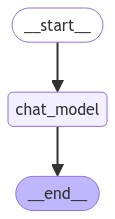

In [40]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! In addition to whales, there are several other fascinating ocean mammals worth studying. Here are a few:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are closely related to whales. There are many species, including the common bottlenose dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter. They are less acrobatic and not as well-known but equally interesting.

3. **Seals**: These are pinnipeds, meaning "fin-footed." They spend a lot of time in the water but come ashore to rest, breed, and give birth. Examples include the harbor seal and the elephant seal.

## Reducer

A practical challenge when working with messages is managining long-running conversations!

This results in high token usage and latency if we are not careful.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage`! 

The `add_messages` reducer can remove mesages from our state. 

Here's I'll define the full `MessagesState` to show that we are using `add_messages` reducer.

```
class MessagesState(TypedDict):
messages: Annotated[list[AnyMessage], add_messages]
```

But, usually I prefer to just use `from langgraph.graph import MessagesState` directly.

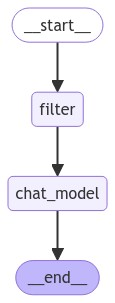

In [122]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langchain_core.messages import RemoveMessage

from langgraph.graph.message import add_messages

def concat_up_to_five(current: list, new: list):
    return (current + new)[-5:]
        
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [123]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, also known as killer whales, are found in oceans all around the world. They are highly adaptable and can live in a variety of marine environments. Here are some of the key regions where orcas are commonly found:

1. **Arctic and Antarctic Waters:** Orcas are often seen in the cold waters of the Arctic and Antarctic regions. They are well-adapted to the frigid temperatures and are known to prey on seals, fish, and even other whales in these areas.

2. **North Atlantic and North Pacific Oceans:** Orcas are frequently spotted along the coastlines of countries bordering these oceans. In the North Atlantic, they can be seen off th

## Filtering messages

Of course, messages are simply a list that can be [filtered easily](https://langchain-ai.github.io/langgraph/how-tos/memory/manage-conversation-history/#filtering-messages).

There are a few ways to approach this in LangGraph.

One option is to [use `RemoveMessage`](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) to [remove messages from graph state](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/) based upon the message ID.

When using our built-in `MessagesState`, the reducer understands `RemoveMessage`. 

In [67]:
from langchain_core.messages import RemoveMessage

In [107]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id=1)]
messages.append(HumanMessage("Hi.", name="Lance", id=2))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id=3))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id=4))

# Delete all but the 2 most recent messages
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]


We can apply this in our graph.

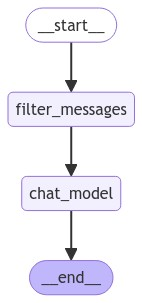

In [80]:
# Node
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(messages)]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("filter_messages", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

The order here is the order in which we send the state updates.

In [81]:
# Run
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Remove Message ================================


================================ Remove Message ================================


================================== Ai Message ==================================

That's great that you know about whales! There are several other fascinating ocean mammals you might want to look into:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication.

2. **Seals and Sea Lions**: These pinnipeds are skilled swimmers and can often be seen lounging on rocks or beaches. Seals tend to have smaller flippers and lack external ear flaps, while sea lions have 

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the llm.

Optionally, we can use [LangSmith](https://docs.smith.langchain.com/) here to view the traces for our chat model invocations confirm the filtered messages are going in.

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" 

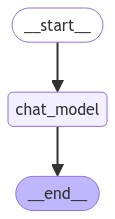

In [92]:
# Node
def chat_model_node(state: MessagesState):
    messages = filter_messages(state["messages"])
    return {"messages": [llm.invoke(messages[-1:])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!
================================== Ai Message ==================================

That's great that you know about whales! There are several other fascinating ocean mammals you might want to look into:

1. **Dolphins**: Highly intelligent and social animals, dol

In [94]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================

That's great that you know about whales! There are several other fascinating ocean mammals you might want to look into:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication.

2. **Seals and Sea Lions**: These pinnipeds are skilled swimmers and can often be seen lounging on rocks or beaches. Seals tend to have smaller flippers and lack external ear flaps, while sea lions have larger flippers and visible ear flaps.

3. **Manatees and Dugongs**: Often referred to as sea cows, these gentle giants are herbivores that graze on underwater vegetation. Manatees are typically found in the Atlantic Ocean, while dugongs inhabit the Indian and Pacific Oceans.

4. **Otters**: Sea otters are known for their use of tools to open shellfish, while river otters are excellent swimmers and can often be seen in coastal areas.

5. **Narwhals**: Often ca

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can respond with.

See the `trim_messages` below.

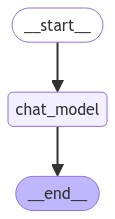

In [115]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=500,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True,
        )
    return {"messages": [llm.invoke(messages)]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [109]:
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [112]:
trim_messages(
            messages,
            max_tokens=500,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
        )

[AIMessage(content='Hi.', name='Bot', id='1'),
 HumanMessage(content='Hi.', name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4'),
 HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [117]:
# Invoke, using message trimming
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r